In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import sys

sys.path.append("..")
from data_utils import data_process, batchify, get_batch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/svendroste/repos/torch_examples/transformer2/.env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [3]:
from torch.utils.data import dataset
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


train_iter = WikiText2(split="train")
tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter, vocab, tokenizer)
val_data = data_process(val_iter, vocab, tokenizer)
test_data = data_process(test_iter, vocab, tokenizer)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size, device)
val_data = batchify(val_data, eval_batch_size, device)
test_data = batchify(test_data, eval_batch_size, device)

In [4]:
idx2word = {i: x for i, x in enumerate(vocab.get_itos())}

def to_sentence(x):
    return " ".join([idx2word[int(idx)] for idx in x])

def to_tokens(x):
    return [idx2word[int(idx)] for idx in x]

data, _ = get_batch(train_data, batch_size*2, bptt=100)
to_sentence(data[:, 0])

'video game developed by sega and media . vision for the playstation portable . released in january 2011 in japan , it is the third game in the valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the nameless , a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit <unk> raven . the game began development in 2010 , carrying over a large portion'

## Model

In [5]:
from torch import nn, Tensor
from multihead_attention import MultiheadAttention

In [16]:
def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float("-inf"), diagonal=1)

class Model(nn.Module):
    def __init__(self, n_tokens, D, B, n_heads):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, D)
        self.encoder = MultiheadAttention(D, n_heads, bias=True)
        self.decoder = nn.Linear(D, n_tokens)
        
        self._init_parameters()
    
    def _init_parameters(self):
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-0.1, 0.1)

    def forward(self, src, attn_mask):
        """ 
        Args: 
            src: tensor, shape [B, N]
        """
        # (B, N, D)
        src = self.embedding(src)
        # print("embedding  : ", src.shape)
        
        # (B, N, D), (B, n_heads, N, N)
        attn_output, attn_mask =self.encoder(src, src, src, attn_mask = attn_mask)
        
        # (B, N, n_tokens)
        output = self.decoder(attn_output)
        return output, attn_mask
        
        
D = 8
N = 8
n_heads = 4
n_tokens = len(vocab)        

model = Model(n_tokens, D, batch_size, n_heads)
mask = generate_square_subsequent_mask(N)

## Train

In [17]:
lr = 5.0
log_interval = 200
max_batches = 5000

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)

In [18]:
model.train()
total_loss = 0
for b, i in enumerate(range(0, len(train_data), batch_size)):
    data, targets = get_batch(train_data, i, bptt=N)
    if data.shape[1] != batch_size:
        print("incomplete")
        break
        
    output, attn_mask = model(data.t(), mask)
    
    loss = criterion(output.view(-1, n_tokens), targets)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    
    total_loss += loss.item()
    
    if b % log_interval == 0 and i !=0:
        lr = scheduler.get_last_lr()[0]
        print(f"({b}) loss: {total_loss/log_interval:<.3f} | lr: {lr:<.3f}")
        scheduler.step()
        total_loss = 0
        
    if b % max_batches == 0 and b != 0:
        break

(200) loss: 8.023 | lr: 5.000
(400) loss: 7.352 | lr: 4.750
(600) loss: 7.159 | lr: 4.513
(800) loss: 7.003 | lr: 4.287
(1000) loss: 6.946 | lr: 4.073
(1200) loss: 6.894 | lr: 3.869
(1400) loss: 6.824 | lr: 3.675
(1600) loss: 6.818 | lr: 3.492
(1800) loss: 6.767 | lr: 3.317
(2000) loss: 6.748 | lr: 3.151
(2200) loss: 6.764 | lr: 2.994
(2400) loss: 6.681 | lr: 2.844
(2600) loss: 6.721 | lr: 2.702
(2800) loss: 6.656 | lr: 2.567
(3000) loss: 6.631 | lr: 2.438
(3200) loss: 6.657 | lr: 2.316
(3400) loss: 6.613 | lr: 2.201
(3600) loss: 6.585 | lr: 2.091
(3800) loss: 6.531 | lr: 1.986
(4000) loss: 6.563 | lr: 1.887
(4200) loss: 6.557 | lr: 1.792
(4400) loss: 6.570 | lr: 1.703
(4600) loss: 6.484 | lr: 1.618
(4800) loss: 6.500 | lr: 1.537
(5000) loss: 6.493 | lr: 1.460


### look at attn_mask

output sentence: <unk> the <unk> <unk> . the <unk> .


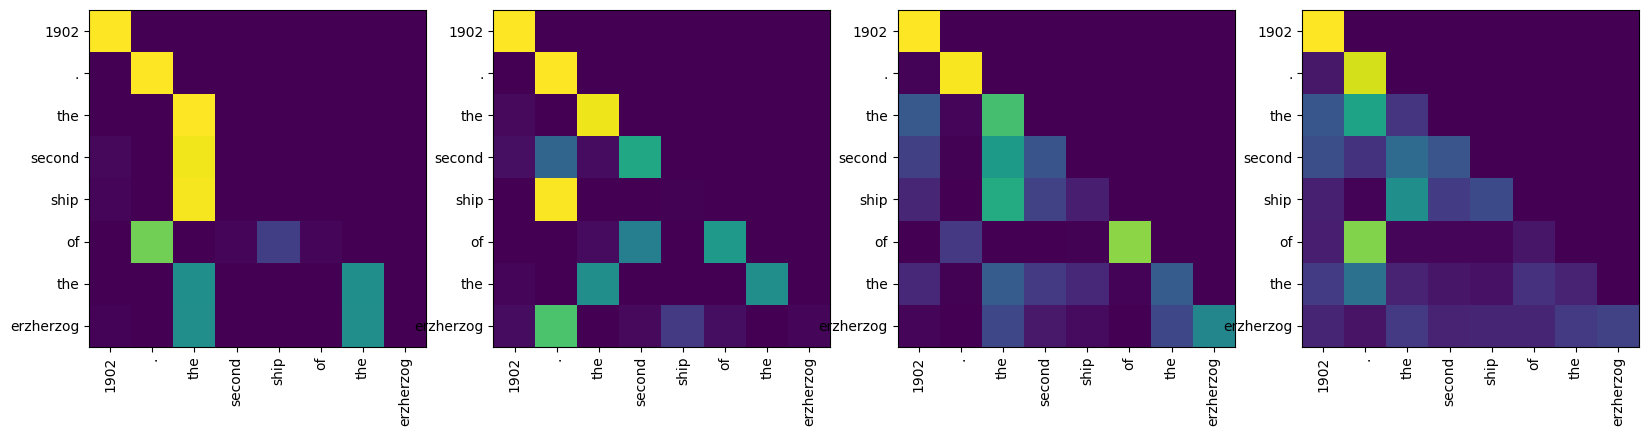

In [20]:
import matplotlib.pyplot as plt
import random

model.eval()

idx = random.randint(0, train_data.size(0))
data, targets = get_batch(train_data, idx , bptt=N)
data = data[:, :1]


output, attn_mask = model(data.t(), mask)

output_sentence = to_sentence(output.argmax(-1).squeeze())
print(f"output sentence: {output_sentence}")

labels = to_tokens(data.squeeze())

_, ax = plt.subplots(1, max(n_heads, 2), figsize=(5 * n_heads, 5))
for i in range(n_heads):
    ax[i].imshow(attn_mask[0, i].detach())

    ax[i].set_xticks(range(N))
    ax[i].set_yticks(range(N))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticklabels(labels, rotation=0)
    
plt.show()